# Import dataset

In [1]:
# Import libraries

import os
import tqdm
import shutil
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [2]:
# Set seed for reproducibility

seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Load the dataset

dataset_dir = '../input/training-dataset-homework1zip/training_data_final'


# Metadata

epochs = 200
batch_size= 16
input_shape = (96, 96, 3)

In [4]:
# Create an instance of ImageDataGenerator for training and validation sets

train_data_gen = ImageDataGenerator(validation_split=0.1)

valid_data_gen = ImageDataGenerator(validation_split=0.1)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method

train_data_gen = train_data_gen.flow_from_directory(directory=dataset_dir, 
                                               target_size=(96, 96), 
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=batch_size, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed,
                                               subset = 'training')

valid_data_gen = valid_data_gen.flow_from_directory(directory=dataset_dir, 
                                           target_size=(96, 96), 
                                           color_mode='rgb',
                                           classes=None,
                                           batch_size=batch_size, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=seed,
                                           subset = 'validation')

Found 3191 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


In [5]:
# Assess some data

print("Assigned labels")
print(train_data_gen.class_indices)
print()
print("Target classes")
print(train_data_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


# Transfer learning

In [6]:
# Install tqdm to retrieve x,y for training and validation

!pip install tqdm

In [7]:
# Retrieve x,y for training and validation sets

train_data_gen.reset()
X_train, y_train = next(train_data_gen)
for i in tqdm.tqdm(range(int(train_data_gen.n/batch_size)-1)): 
    img, label = next(train_data_gen)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)

valid_data_gen.reset()
X_val, y_val = next(valid_data_gen)
for i in tqdm.tqdm(range(int(valid_data_gen.n/batch_size)-1)): 
    img, label = next(valid_data_gen)
    X_val = np.append(X_val, img, axis=0 )
    y_val = np.append(y_val, label, axis=0)

100%|██████████| 20/20 [00:00<00:00, 21.76it/s]


In [8]:
# Preprocess images of training and validation sets

X_train_ft = preprocess_input(X_train)
X_val_ft = preprocess_input(X_val)

In [9]:
# Import ResNet50

supernet = tfk.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(192,192,3)
)
supernet.summary()
#tfk.utils.plot_model(supernet)

2022-11-26 18:43:02.215752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:43:02.390127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:43:02.391014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:43:02.392978: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
__________________________

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 192, 192, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
Gap (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Classifier (Dense)           (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

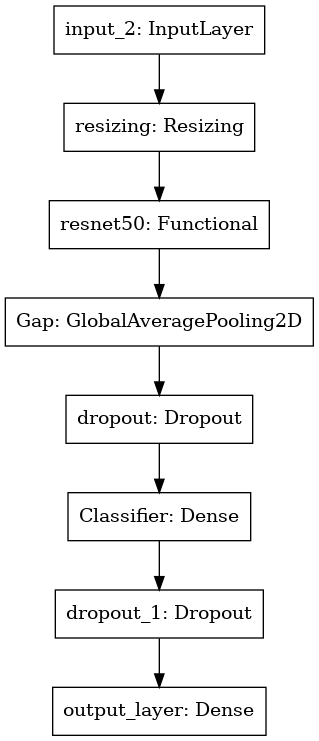

In [10]:
# Use the supernet as feature extractor -> to keep fixed the value of weight

supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = tfkl.Resizing(192, 192, interpolation="bicubic")(inputs)
x = supernet(x)
gap_layer = tfkl.GlobalAveragePooling2D(name='Gap')(x)
dropout = tfkl.Dropout(0.35, seed=seed)(gap_layer)
classifier_layer = tfkl.Dense(units=256, name='Classifier', 
                              kernel_initializer=tfk.initializers.HeUniform(seed), 
                              activation='relu'
                              )(dropout)
dropout = tfkl.Dropout(0.35, seed=seed)(classifier_layer)
output_layer = tfkl.Dense(units=8, activation='softmax', 
                              kernel_initializer=tfk.initializers.HeUniform(seed), 
                              name='output_layer'
                              )(dropout)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 0.00025), metrics='accuracy')
model.summary()

tfk.utils.plot_model(model)

In [11]:
# Train the model

history = model.fit(
    x = X_train_ft,
    y = y_train,
    batch_size = batch_size,
    epochs = 200,
    validation_data = (X_val_ft, y_val),
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                mode='max', 
                                                patience=10, 
                                                restore_best_weights=True)
).history

2022-11-26 18:43:09.383501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-11-26 18:43:13.062894: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


199/199 [==============================] - 17s 39ms/step - loss: 1.4927 - accuracy: 0.4736 - val_loss: 0.9439 - val_accuracy: 0.6637
Epoch 2/200
199/199 [==============================] - 7s 34ms/step - loss: 1.0133 - accuracy: 0.6426 - val_loss: 0.8315 - val_accuracy: 0.6964
Epoch 3/200
199/199 [==============================] - 7s 34ms/step - loss: 0.8780 - accuracy: 0.6840 - val_loss: 0.7367 - val_accuracy: 0.7560
Epoch 4/200
199/199 [==============================] - 7s 33ms/step - loss: 0.7746 - accuracy: 0.7148 - val_loss: 0.6884 - val_accuracy: 0.7589
Epoch 5/200
199/199 [==============================] - 7s 33ms/step - loss: 0.7395 - accuracy: 0.7381 - val_loss: 0.6494 - val_accuracy: 0.7768
Epoch 6/200
199/199 [==============================] - 7s 34ms/step - loss: 0.6589 - accuracy: 0.7638 - val_loss: 0.6098 - val_accuracy: 0.7917
Epoch 7/200
199/199 [==============================] - 7s 33ms/step - loss: 0.6417 - accuracy: 0.7666 - val_loss: 0.6077 - val_accuracy: 0.7857
Epo

In [12]:
# Save best epoch model

model.save("SubmissionModel")

2022-11-26 18:47:44.450816: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [13]:
# Make a zip to download the model

shutil.make_archive("SubmissionModel", 'zip', "./SubmissionModel")

'/kaggle/working/SubmissionModel.zip'

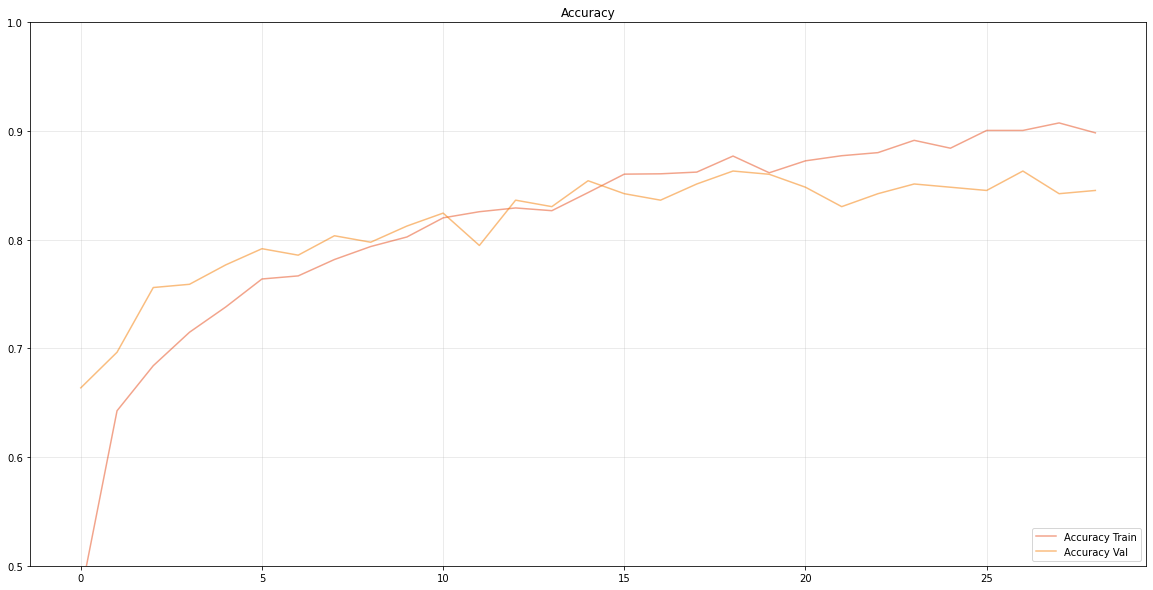

In [14]:
# Plot accuracy graph

plt.figure(figsize=(20,10))

ALPHA = 0.5
 
plt.plot(history['accuracy'], label='Accuracy Train', alpha=ALPHA, color='#E64A19') 
plt.plot(history['val_accuracy'], label='Accuracy Val', alpha=ALPHA, color='#F57C00') 
 
plt.ylim(.5, 1) 
plt.title('Accuracy') 
plt.legend(loc='lower right') 
plt.grid(alpha=.3) 
plt.show()

Accuracy: 0.8631
Precision: 0.861
Recall: 0.8321
F1: 0.8415


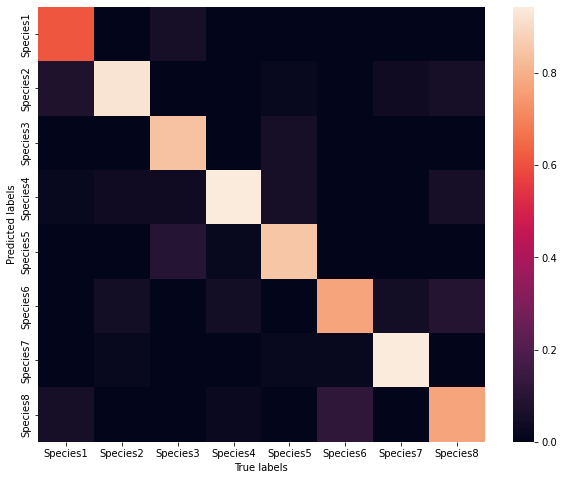

In [15]:
# Plot confusion matrix

# Predict the validation set
predictions = model.predict(X_val_ft)
predictions.shape

labels = {0:'Species1',       # 0
          1:'Species2',       # 1
          2:'Species3',       # 2
          3:'Species4',       # 3
          4:'Species5',       # 4
          5:'Species6',       # 5
          6:'Species7',       # 6
          7:'Species8'}       # 7

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

cm = cm /cm.astype(float).sum(axis=1);

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [18]:
# Print some statistics

print( classification_report(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1)) )

              precision    recall  f1-score   support

           0       0.92      0.61      0.73        18
           1       0.83      0.92      0.88        53
           2       0.93      0.84      0.89        51
           3       0.81      0.94      0.87        51
           4       0.88      0.85      0.87        53
           5       0.77      0.77      0.77        22
           6       0.94      0.94      0.94        53
           7       0.79      0.77      0.78        35

    accuracy                           0.86       336
   macro avg       0.86      0.83      0.84       336
weighted avg       0.87      0.86      0.86       336



In [19]:
# Retrieve again plain images in validation set to visualize them with the predictions

valid_data_gen.reset()
X_val_show, _ = next(valid_data_gen)
for i in tqdm.tqdm(range(int(valid_data_gen.n/batch_size)-1)): 
    img, _ = next(valid_data_gen)
    X_val_show = np.append(X_val_show, img, axis=0)

100%|██████████| 20/20 [00:00<00:00, 45.23it/s]


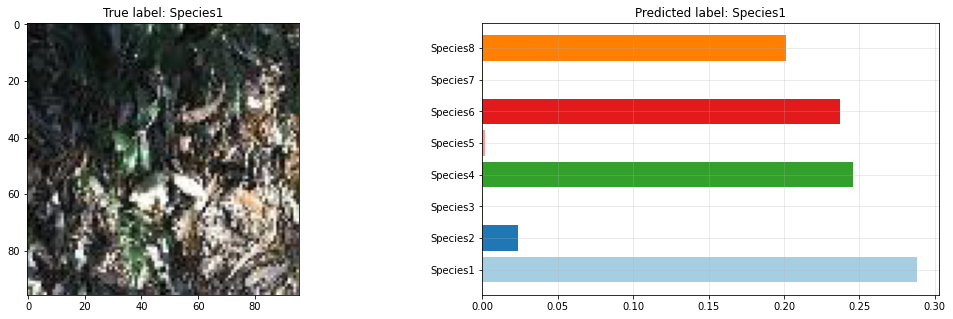

In [25]:
# Plot the target images and the predictions

prediction_index = 14

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)
ax1.imshow(np.uint8(X_val_show[prediction_index]))
ax1.set_title('True label: '+labels[np.argmax(y_val[prediction_index])])
ax2.barh(list(labels.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions[prediction_index])])
ax2.grid(alpha=.3)
plt.show()